# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [4]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

In [5]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [6]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883) 7
- 1025 (train: 880,  test: 145) 7e

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [7]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name="fashion_mnist",
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [8]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [9]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [10]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [11]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [10]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.63372439990441

In [11]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

27.624756759032607

#### Trained to ...

In [12]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

28.4165061848859

In [13]:
calc_mutlimodel_metric_average(modeltype1=trained_ms, modeltype2=trained_ms, metric="l2_norm")

0.0

#### Exact to ...

In [14]:
# see above

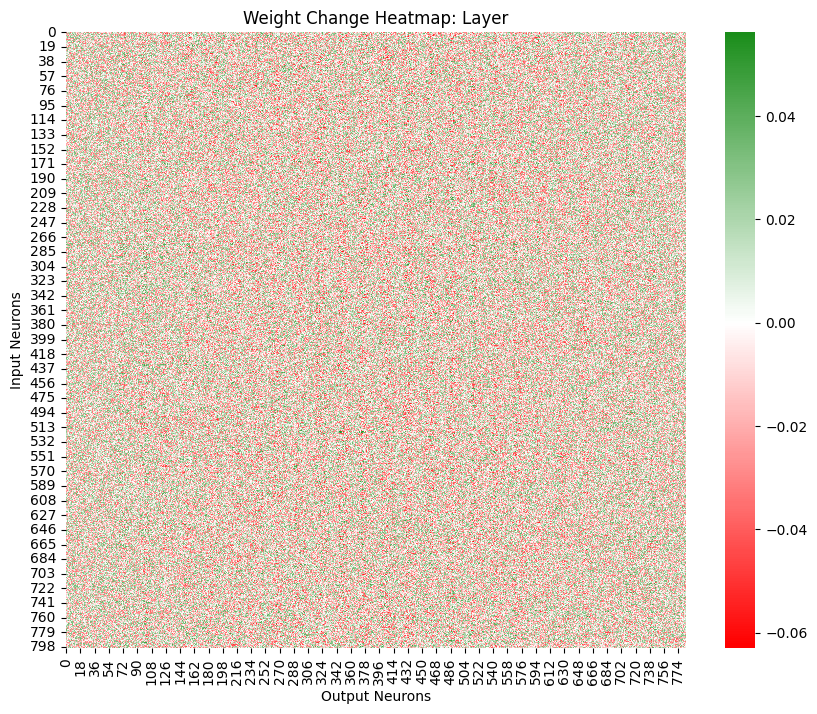

In [16]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[0].fc1.weight, weights_after=torch.zeros_like(exact_ms[0].fc1.weight))

### Layer-wise Comparison

In [18]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), exact_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 15435.598567708334,
 'fc1.bias': 19.47081864674886,
 'fc3.weight': 259.3187840779622,
 'fc3.bias': 0.23527605086565018}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [12]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [20]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.4498659197595856

In [21]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.1154377940509999

#### Trained to...

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.22993103854713

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.2739539988250251

#### Exact to...

In [24]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.5821822917177568

In [25]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.25426572916053586

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [13]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.0998 - Standard Deviation for D_gesamt: 0.0251


Average Accuracy for D_remain: 0.1004 - Standard Deviation for D_remain: 0.0288


Average Accuracy for 0: 0.1256 - Standard Deviation for 0: 0.2040


Average Accuracy for 1: 0.0759 - Standard Deviation for 1: 0.1590


Average Accuracy for 2: 0.1150 - Standard Deviation for 2: 0.2030


Average Accuracy for 3: 0.1477 - Standard Deviation for 3: 0.2347


Average Accuracy for 4: 0.0776 - Standard Deviation for 4: 0.1018


Average Accuracy for 5: 0.0958 - Standard Deviation for 5: 0.1351


Average Accuracy for 6: 0.0835 - Standard Deviation for 6: 0.1449


Average Accuracy for 8: 0.0787 - Standard Deviation for 8: 0.1449


Average Accuracy for 9: 0.1039 - Standard Deviation for 9: 0.1914


Average Accuracy for 7_all: 0.0951 - Standard Deviation for 7_all: 0.1314


Average Accuracy for 7_remain: 0.1058 - Standard Deviation for 7_remain: 0.1476


Average Accuracy for 7_erased: 0.0934 - Standard Deviation for 7_erased: 0.1309
plotting...


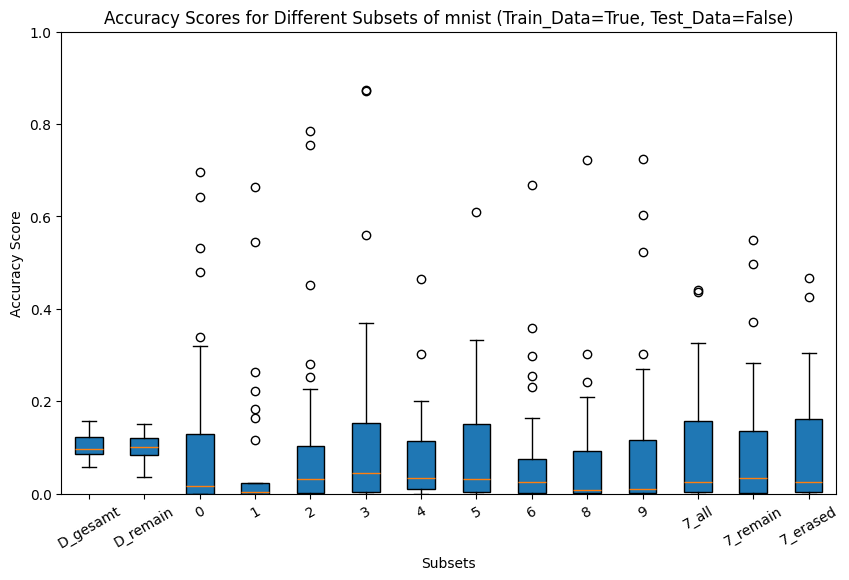

In [27]:
accs["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.0998 - Standard Deviation for D_gesamt: 0.0256


Average Accuracy for D_remain: 0.1006 - Standard Deviation for D_remain: 0.0295


Average Accuracy for 0: 0.1232 - Standard Deviation for 0: 0.2039


Average Accuracy for 1: 0.0749 - Standard Deviation for 1: 0.1597


Average Accuracy for 2: 0.1150 - Standard Deviation for 2: 0.2065


Average Accuracy for 3: 0.1508 - Standard Deviation for 3: 0.2422


Average Accuracy for 4: 0.0776 - Standard Deviation for 4: 0.1033


Average Accuracy for 5: 0.0976 - Standard Deviation for 5: 0.1432


Average Accuracy for 6: 0.0832 - Standard Deviation for 6: 0.1483


Average Accuracy for 8: 0.0802 - Standard Deviation for 8: 0.1561


Average Accuracy for 9: 0.1026 - Standard Deviation for 9: 0.1893


Average Accuracy for 7_all: 0.0943 - Standard Deviation for 7_all: 0.1311


Average Accuracy for 7_remain: 0.1094 - Standard Deviation for 7_remain: 0.1522


Average Accuracy for 7_erased: 0.0919 - Standard Deviation for 7_erased: 0.1306
plotting...


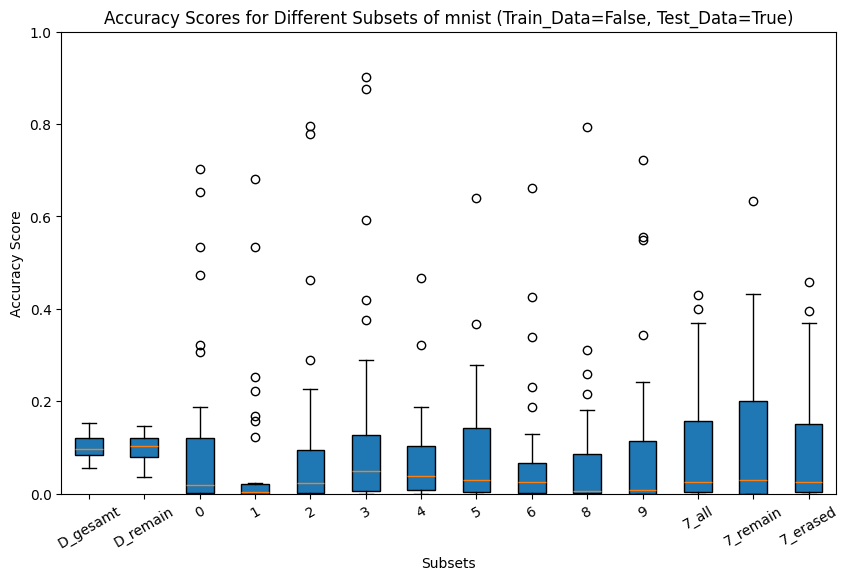

In [28]:
accs["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8699 - Standard Deviation for D_gesamt: 0.0010


Average Accuracy for D_remain: 0.8649 - Standard Deviation for D_remain: 0.0011


Average Accuracy for 0: 0.9448 - Standard Deviation for 0: 0.0017


Average Accuracy for 1: 0.9556 - Standard Deviation for 1: 0.0020


Average Accuracy for 2: 0.8361 - Standard Deviation for 2: 0.0031


Average Accuracy for 3: 0.8427 - Standard Deviation for 3: 0.0032


Average Accuracy for 4: 0.8737 - Standard Deviation for 4: 0.0050


Average Accuracy for 5: 0.7665 - Standard Deviation for 5: 0.0052


Average Accuracy for 6: 0.9269 - Standard Deviation for 6: 0.0023


Average Accuracy for 8: 0.8085 - Standard Deviation for 8: 0.0037


Average Accuracy for 9: 0.8413 - Standard Deviation for 9: 0.0034


Average Accuracy for 7_all: 0.8825 - Standard Deviation for 7_all: 0.0021


Average Accuracy for 7_remain: 0.6412 - Standard Deviation for 7_remain: 0.0103


Average Accuracy for 7_erased: 0.9205 - Standard Deviation for 7_erased: 0.0024
plotting...


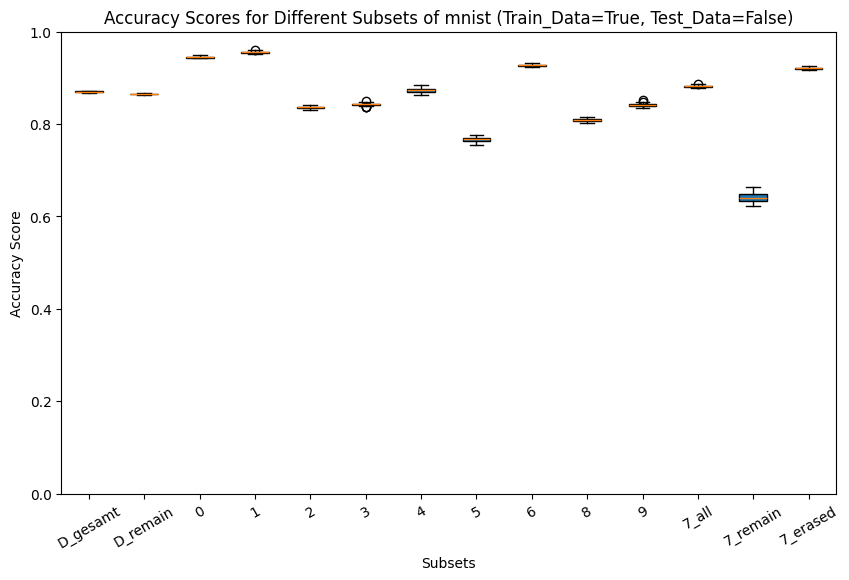

In [29]:
accs["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8778 - Standard Deviation for D_gesamt: 0.0015


Average Accuracy for D_remain: 0.8735 - Standard Deviation for D_remain: 0.0016


Average Accuracy for 0: 0.9627 - Standard Deviation for 0: 0.0018


Average Accuracy for 1: 0.9627 - Standard Deviation for 1: 0.0039


Average Accuracy for 2: 0.8384 - Standard Deviation for 2: 0.0042


Average Accuracy for 3: 0.8720 - Standard Deviation for 3: 0.0036


Average Accuracy for 4: 0.8911 - Standard Deviation for 4: 0.0060


Average Accuracy for 5: 0.7570 - Standard Deviation for 5: 0.0068


Average Accuracy for 6: 0.9201 - Standard Deviation for 6: 0.0034


Average Accuracy for 8: 0.8310 - Standard Deviation for 8: 0.0050


Average Accuracy for 9: 0.8505 - Standard Deviation for 9: 0.0054


Average Accuracy for 7_all: 0.8722 - Standard Deviation for 7_all: 0.0027


Average Accuracy for 7_remain: 0.5525 - Standard Deviation for 7_remain: 0.0154


Average Accuracy for 7_erased: 0.9222 - Standard Deviation for 7_erased: 0.0028
plotting...


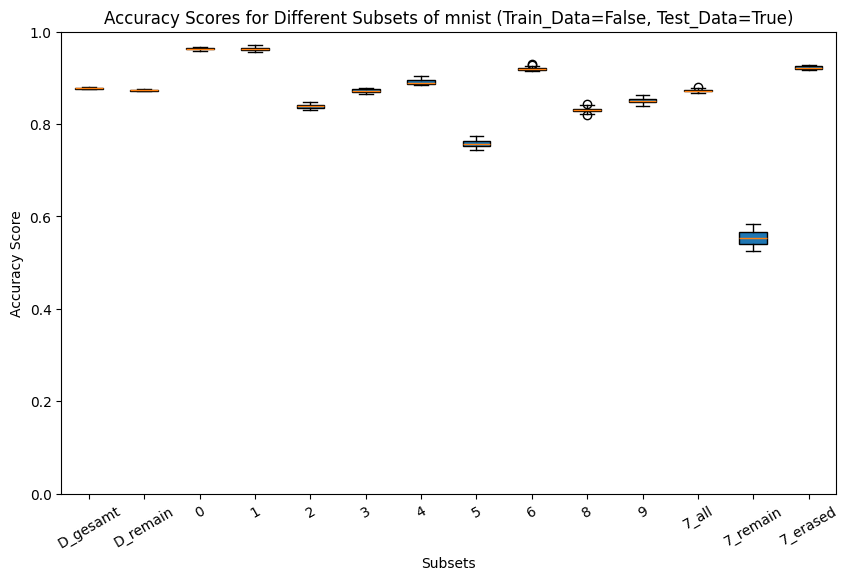

In [14]:
accs["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8420 - Standard Deviation for D_gesamt: 0.0019


Average Accuracy for D_remain: 0.8656 - Standard Deviation for D_remain: 0.0019


Average Accuracy for 0: 0.9445 - Standard Deviation for 0: 0.0039


Average Accuracy for 1: 0.9542 - Standard Deviation for 1: 0.0043


Average Accuracy for 2: 0.8195 - Standard Deviation for 2: 0.0040


Average Accuracy for 3: 0.8367 - Standard Deviation for 3: 0.0049


Average Accuracy for 4: 0.8645 - Standard Deviation for 4: 0.0082


Average Accuracy for 5: 0.7654 - Standard Deviation for 5: 0.0099


Average Accuracy for 6: 0.9265 - Standard Deviation for 6: 0.0040


Average Accuracy for 8: 0.8054 - Standard Deviation for 8: 0.0068


Average Accuracy for 9: 0.8560 - Standard Deviation for 9: 0.0050


Average Accuracy for 7_all: 0.6376 - Standard Deviation for 7_all: 0.0098


Average Accuracy for 7_remain: 0.8503 - Standard Deviation for 7_remain: 0.0037


Average Accuracy for 7_erased: 0.6041 - Standard Deviation for 7_erased: 0.0111
plotting...


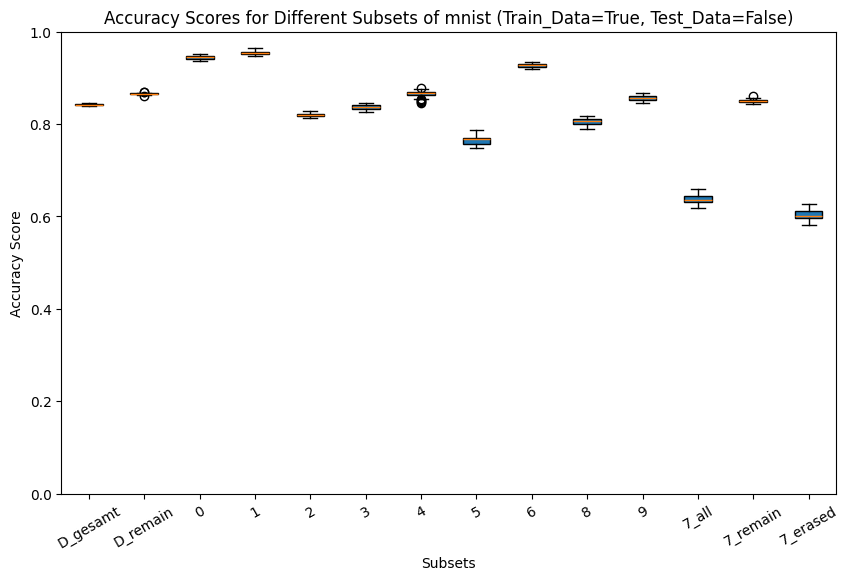

In [15]:
accs["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8539 - Standard Deviation for D_gesamt: 0.0024


Average Accuracy for D_remain: 0.8747 - Standard Deviation for D_remain: 0.0023


Average Accuracy for 0: 0.9606 - Standard Deviation for 0: 0.0045


Average Accuracy for 1: 0.9614 - Standard Deviation for 1: 0.0068


Average Accuracy for 2: 0.8214 - Standard Deviation for 2: 0.0043


Average Accuracy for 3: 0.8693 - Standard Deviation for 3: 0.0060


Average Accuracy for 4: 0.8763 - Standard Deviation for 4: 0.0094


Average Accuracy for 5: 0.7618 - Standard Deviation for 5: 0.0118


Average Accuracy for 6: 0.9221 - Standard Deviation for 6: 0.0044


Average Accuracy for 8: 0.8275 - Standard Deviation for 8: 0.0073


Average Accuracy for 9: 0.8640 - Standard Deviation for 9: 0.0068


Average Accuracy for 7_all: 0.6607 - Standard Deviation for 7_all: 0.0107


Average Accuracy for 7_remain: 0.7923 - Standard Deviation for 7_remain: 0.0078


Average Accuracy for 7_erased: 0.6401 - Standard Deviation for 7_erased: 0.0121
plotting...


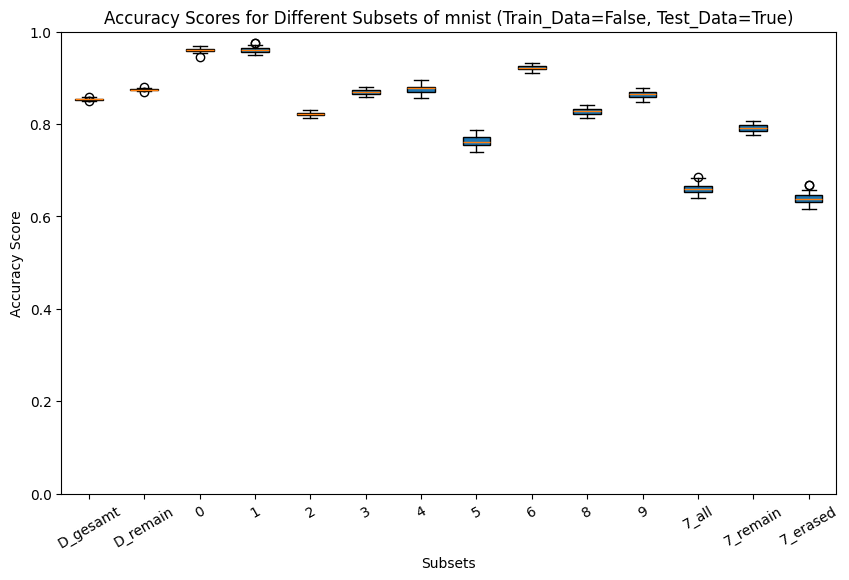

In [16]:
accs["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [17]:
losses = {}

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.2882 - Standard Deviation for D_gesamt: 0.0010


Average Loss for D_remain: 0.2883 - Standard Deviation for D_remain: 0.0011


Average Loss for 0: 0.2891 - Standard Deviation for 0: 0.0104


Average Loss for 1: 0.2899 - Standard Deviation for 1: 0.0058


Average Loss for 2: 0.2874 - Standard Deviation for 2: 0.0080


Average Loss for 3: 0.2869 - Standard Deviation for 3: 0.0090


Average Loss for 4: 0.2871 - Standard Deviation for 4: 0.0057


Average Loss for 5: 0.2887 - Standard Deviation for 5: 0.0075


Average Loss for 6: 0.2877 - Standard Deviation for 6: 0.0059


Average Loss for 8: 0.2896 - Standard Deviation for 8: 0.0081


Average Loss for 9: 0.2892 - Standard Deviation for 9: 0.0072


Average Loss for 7_all: 0.2880 - Standard Deviation for 7_all: 0.0067


Average Loss for 7_remain: 0.2890 - Standard Deviation for 7_remain: 0.0074


Average Loss for 7_erased: 0.2879 - Standard Deviation for 7_erased: 0.0066
plotting...


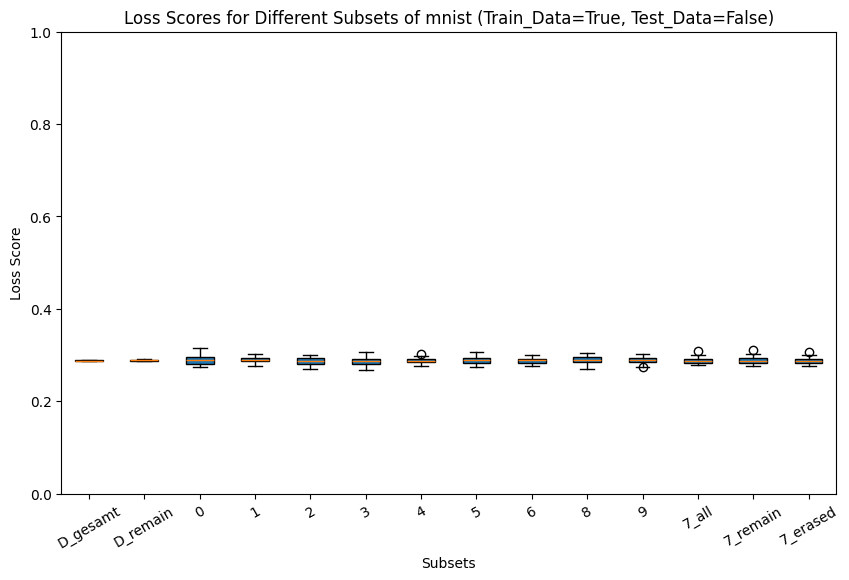

In [18]:
losses["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.2882 - Standard Deviation for D_gesamt: 0.0010


Average Loss for D_remain: 0.2883 - Standard Deviation for D_remain: 0.0012


Average Loss for 0: 0.2900 - Standard Deviation for 0: 0.0103


Average Loss for 1: 0.2901 - Standard Deviation for 1: 0.0059


Average Loss for 2: 0.2874 - Standard Deviation for 2: 0.0082


Average Loss for 3: 0.2883 - Standard Deviation for 3: 0.0091


Average Loss for 4: 0.2874 - Standard Deviation for 4: 0.0057


Average Loss for 5: 0.2899 - Standard Deviation for 5: 0.0078


Average Loss for 6: 0.2883 - Standard Deviation for 6: 0.0061


Average Loss for 8: 0.2898 - Standard Deviation for 8: 0.0082


Average Loss for 9: 0.2911 - Standard Deviation for 9: 0.0073


Average Loss for 7_all: 0.2888 - Standard Deviation for 7_all: 0.0067


Average Loss for 7_remain: 0.2980 - Standard Deviation for 7_remain: 0.0075


Average Loss for 7_erased: 0.2899 - Standard Deviation for 7_erased: 0.0067
plotting...


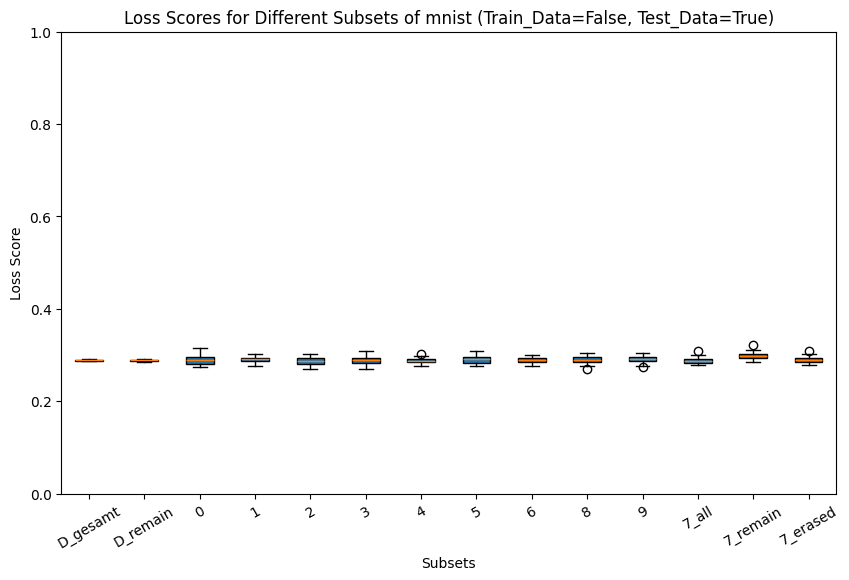

In [19]:
losses["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0743 - Standard Deviation for D_gesamt: 0.0004


Average Loss for D_remain: 0.0763 - Standard Deviation for D_remain: 0.0003


Average Loss for 0: 0.0407 - Standard Deviation for 0: 0.0006


Average Loss for 1: 0.0477 - Standard Deviation for 1: 0.0009


Average Loss for 2: 0.0748 - Standard Deviation for 2: 0.0009


Average Loss for 3: 0.0817 - Standard Deviation for 3: 0.0011


Average Loss for 4: 0.0792 - Standard Deviation for 4: 0.0014


Average Loss for 5: 0.1137 - Standard Deviation for 5: 0.0010


Average Loss for 6: 0.0490 - Standard Deviation for 6: 0.0010


Average Loss for 8: 0.0969 - Standard Deviation for 8: 0.0009


Average Loss for 9: 0.1004 - Standard Deviation for 9: 0.0013


Average Loss for 7_all: 0.0669 - Standard Deviation for 7_all: 0.0009


Average Loss for 7_remain: 0.1443 - Standard Deviation for 7_remain: 0.0028


Average Loss for 7_erased: 0.0546 - Standard Deviation for 7_erased: 0.0010
plotting...


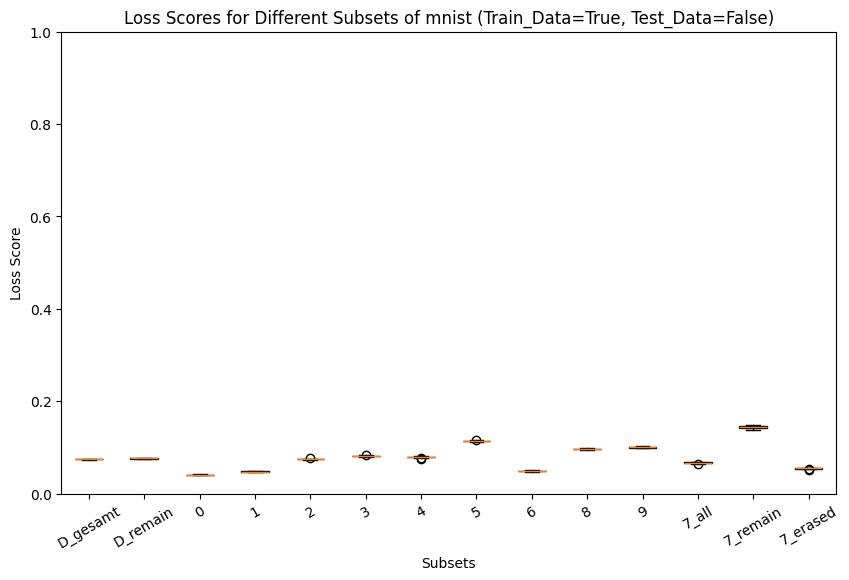

In [20]:
losses["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0717 - Standard Deviation for D_gesamt: 0.0003


Average Loss for D_remain: 0.0736 - Standard Deviation for D_remain: 0.0003


Average Loss for 0: 0.0362 - Standard Deviation for 0: 0.0007


Average Loss for 1: 0.0446 - Standard Deviation for 1: 0.0009


Average Loss for 2: 0.0748 - Standard Deviation for 2: 0.0010


Average Loss for 3: 0.0743 - Standard Deviation for 3: 0.0012


Average Loss for 4: 0.0766 - Standard Deviation for 4: 0.0014


Average Loss for 5: 0.1088 - Standard Deviation for 5: 0.0010


Average Loss for 6: 0.0492 - Standard Deviation for 6: 0.0010


Average Loss for 8: 0.0950 - Standard Deviation for 8: 0.0009


Average Loss for 9: 0.0958 - Standard Deviation for 9: 0.0012


Average Loss for 7_all: 0.0709 - Standard Deviation for 7_all: 0.0009


Average Loss for 7_remain: 0.1927 - Standard Deviation for 7_remain: 0.0034


Average Loss for 7_erased: 0.0531 - Standard Deviation for 7_erased: 0.0009
plotting...


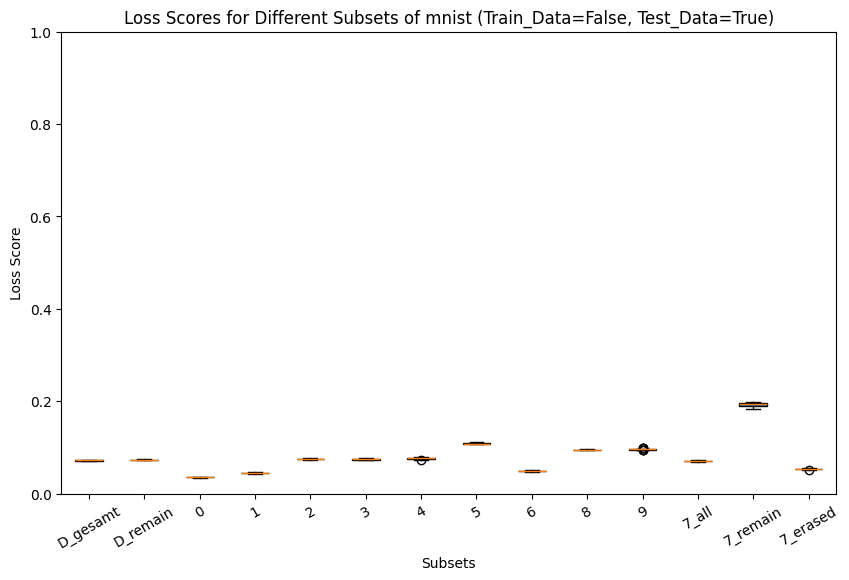

In [21]:
losses["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0815 - Standard Deviation for D_gesamt: 0.0005


Average Loss for D_remain: 0.0765 - Standard Deviation for D_remain: 0.0004


Average Loss for 0: 0.0406 - Standard Deviation for 0: 0.0015


Average Loss for 1: 0.0503 - Standard Deviation for 1: 0.0012


Average Loss for 2: 0.0790 - Standard Deviation for 2: 0.0013


Average Loss for 3: 0.0836 - Standard Deviation for 3: 0.0015


Average Loss for 4: 0.0838 - Standard Deviation for 4: 0.0013


Average Loss for 5: 0.1132 - Standard Deviation for 5: 0.0018


Average Loss for 6: 0.0495 - Standard Deviation for 6: 0.0013


Average Loss for 8: 0.0985 - Standard Deviation for 8: 0.0013


Average Loss for 9: 0.0969 - Standard Deviation for 9: 0.0013


Average Loss for 7_all: 0.1242 - Standard Deviation for 7_all: 0.0028


Average Loss for 7_remain: 0.0775 - Standard Deviation for 7_remain: 0.0011


Average Loss for 7_erased: 0.1316 - Standard Deviation for 7_erased: 0.0032
plotting...


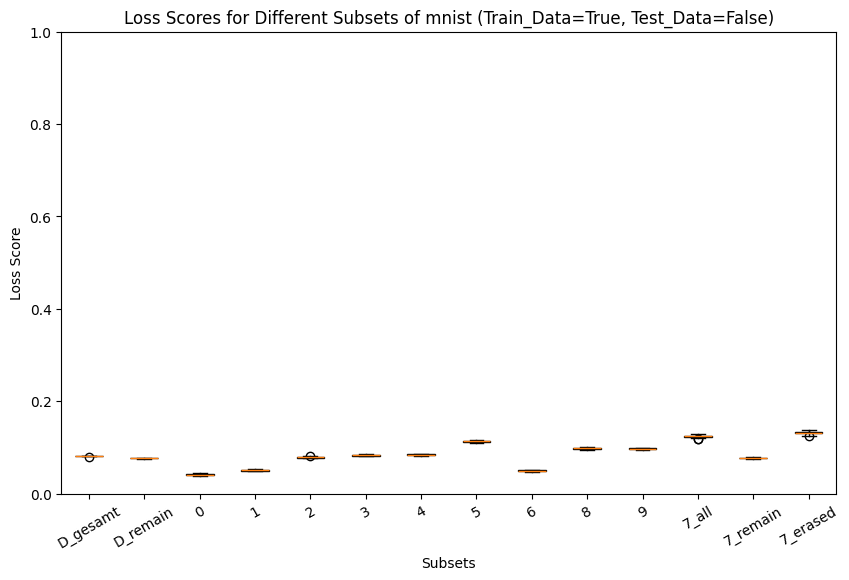

In [22]:
losses["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0776 - Standard Deviation for D_gesamt: 0.0005


Average Loss for D_remain: 0.0735 - Standard Deviation for D_remain: 0.0005


Average Loss for 0: 0.0362 - Standard Deviation for 0: 0.0014


Average Loss for 1: 0.0471 - Standard Deviation for 1: 0.0012


Average Loss for 2: 0.0784 - Standard Deviation for 2: 0.0013


Average Loss for 3: 0.0751 - Standard Deviation for 3: 0.0015


Average Loss for 4: 0.0822 - Standard Deviation for 4: 0.0015


Average Loss for 5: 0.1076 - Standard Deviation for 5: 0.0018


Average Loss for 6: 0.0494 - Standard Deviation for 6: 0.0013


Average Loss for 8: 0.0960 - Standard Deviation for 8: 0.0014


Average Loss for 9: 0.0932 - Standard Deviation for 9: 0.0012


Average Loss for 7_all: 0.1173 - Standard Deviation for 7_all: 0.0025


Average Loss for 7_remain: 0.1005 - Standard Deviation for 7_remain: 0.0014


Average Loss for 7_erased: 0.1214 - Standard Deviation for 7_erased: 0.0029
plotting...


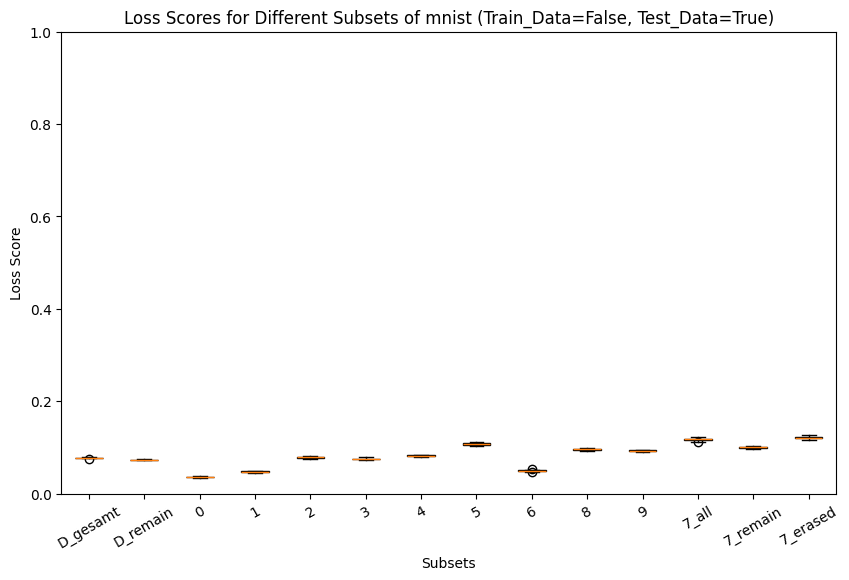

In [23]:
losses["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

___